In [37]:
import pandas as pd 
import numpy as np 
import lightgbm as lgb
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Dataloader import Dataloader

In [21]:
train_x = pd.read_csv('data/train.csv')
train_x = train_x.fillna(0)
drop_columns = ['parking_area','parking_price','txn_floor']
train_x = train_x.drop(drop_columns,axis=1)

In [22]:
train_y = train_x.iloc[:,-1]
train_x = train_x.iloc[:,1:-1]

In [23]:
train_x.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,land_area,building_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,18.144460,3.418175,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,11.387227,4.041309,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,21.426802,5.584279,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,11.387227,13.563031,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,61.306524,4.688108,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [24]:
train_y.head()

0    6.476038e+05
1    3.321452e+06
2    9.570885e+06
3    1.421501e+07
4    7.627120e+05
Name: total_price, dtype: float64

In [25]:
train_x['building_area'].values

array([ 3.41817534,  4.0413088 ,  5.58427885, ...,  8.22364401,
        8.728287  ,  5.35678781])

In [26]:
train_y = train_y/train_x['building_area'].values
print(train_y)

0        1.894589e+05
1        8.218753e+05
2        1.713898e+06
3        1.048070e+06
4        1.626908e+05
5        1.094225e+05
6        1.101481e+06
7        2.104869e+05
8        2.442331e+05
9        1.579535e+06
10       6.140738e+05
11       6.265054e+05
12       6.027707e+05
13       1.254820e+06
14       1.109411e+06
15       4.655162e+05
16       9.436165e+05
17       5.193310e+05
18       1.167744e+06
19       1.001122e+06
20       1.289406e+06
21       1.329530e+06
22       5.370334e+05
23       6.741568e+05
24       4.971438e+05
25       1.002180e+06
26       3.221249e+06
27       3.018493e+05
28       2.583564e+05
29       1.179494e+06
             ...     
59970    2.369766e+05
59971    1.739598e+05
59972    4.320583e+05
59973    1.129905e+06
59974    2.647664e+06
59975    2.042754e+05
59976    1.169281e+06
59977    1.110130e+06
59978    4.430418e+05
59979    5.524989e+05
59980    1.029810e+06
59981    1.157624e+06
59982    7.563599e+05
59983    1.056995e+06
59984    1

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = Dataloader().prepare_train_data(pd.read_csv('data/train.csv'))

KeyError: 'avg_price'

In [28]:
entity_features_columns = ['building_material','city','town','village','building_type','building_use','parking_way']
for col in X_train.columns:
    if "index" in col:
        entity_features_columns.append(col)
print(f"entity_features_columns : {entity_features_columns}")
def score(y,yhat):
    z = 0
    total = 0
    for y1,y2 in zip(yhat,y):
        present = abs(y1-y2)/y2
        total += present
        if(present > 0.1):
            z += 1
    print((1-total/len(y)))
    return z,z/len(y)*10000 + (1-total/len(y))
def custom_loss(y_true, y_pred):
    z , point = score(y_true,y_pred)
    return 'custom_loss',z, False
"""
def custom_loss(y_true, y_pred):
    loss = np.sum(np.abs(y_true-y_pred)/y_true)
    return 'custom_loss',loss, False
"""
def train_LGBM(train, t_target, valid, v_target):
      
    rf = LGBMRegressor(learning_rate=0.1, objective='regression', n_estimators=100000,
                       max_depth=8, num_leaves=128,
                       feature_fraction=0.9, bagging_freq=1,metric='rmse')

    rf.fit(train, t_target, # should we drop the features that are not correlate to our target?
           eval_set=[(train, t_target), (valid, v_target)],
           early_stopping_rounds=50, verbose=10,
           eval_metric='l1',
           categorical_feature=entity_features_columns
           )
    print("Finished.")
    return rf

entity_features_columns : ['building_material', 'city', 'town', 'village', 'building_type', 'building_use', 'parking_way', 'I_index_50', 'I_index_500', 'I_index_1000', 'I_index_5000', 'I_index_10000', 'II_index_50', 'II_index_500', 'II_index_1000', 'II_index_5000', 'II_index_10000', 'III_index_50', 'III_index_500', 'III_index_1000', 'III_index_5000', 'III_index_10000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'IV_index_10000', 'V_index_50', 'V_index_500', 'V_index_1000', 'V_index_5000', 'V_index_10000', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VI_index_5000', 'VI_index_10000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VII_index_5000', 'VII_index_10000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'VIII_index_5000', 'VIII_index_10000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'IX_index_10000', 'X_index_50', 'X_index_500', 'X_index_1000', 'X_index_5000', 'X_index_10000', 'XI_index_50', 'XI_index_500', 'XI_index_1

In [29]:
model = train_LGBM(X_train, y_train, X_test, y_test)

/Users/zhangjingyun/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['III_index_1000', 'III_index_10000', 'III_index_50', 'III_index_500', 'III_index_5000', 'II_index_1000', 'II_index_10000', 'II_index_50', 'II_index_500', 'II_index_5000', 'IV_index_1000', 'IV_index_10000', 'IV_index_50', 'IV_index_500', 'IV_index_5000', 'IX_index_1000', 'IX_index_10000', 'IX_index_50', 'IX_index_500', 'IX_index_5000', 'I_index_1000', 'I_index_10000', 'I_index_50', 'I_index_500', 'I_index_5000', 'VIII_index_1000', 'VIII_index_10000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_5000', 'VII_index_1000', 'VII_index_10000', 'VII_index_50', 'VII_index_500', 'VII_index_5000', 'VI_index_1000', 'VI_index_10000', 'VI_index_50', 'VI_index_500', 'VI_index_5000', 'V_index_1000', 'V_index_10000', 'V_index_50', 'V_index_500', 'V_index_5000', 'XIII_index_1000', 'XIII_index_10000', 'XIII_index_50', 'XIII_index_500', 'X

Training until validation scores don't improve for 50 rounds.
[10]	training's l1: 894227	valid_1's l1: 878466
[20]	training's l1: 893431	valid_1's l1: 877674
[30]	training's l1: 892630	valid_1's l1: 876879
[40]	training's l1: 891839	valid_1's l1: 876095
[50]	training's l1: 891025	valid_1's l1: 875289
[60]	training's l1: 890210	valid_1's l1: 874484
[70]	training's l1: 889396	valid_1's l1: 873679
[80]	training's l1: 888581	valid_1's l1: 872873
[90]	training's l1: 887769	valid_1's l1: 872070
[100]	training's l1: 886970	valid_1's l1: 871278
[110]	training's l1: 886181	valid_1's l1: 870495
[120]	training's l1: 885397	valid_1's l1: 869716
[130]	training's l1: 884608	valid_1's l1: 868931
[140]	training's l1: 883823	valid_1's l1: 868150
[150]	training's l1: 883041	valid_1's l1: 867374
[160]	training's l1: 882258	valid_1's l1: 866597
[170]	training's l1: 881474	valid_1's l1: 865818
[180]	training's l1: 880677	valid_1's l1: 865028
[190]	training's l1: 879879	valid_1's l1: 864235
[200]	training's

[1660]	training's l1: 770197	valid_1's l1: 755798
[1670]	training's l1: 769470	valid_1's l1: 755078
[1680]	training's l1: 768742	valid_1's l1: 754360
[1690]	training's l1: 768026	valid_1's l1: 753650
[1700]	training's l1: 767300	valid_1's l1: 752931
[1710]	training's l1: 766581	valid_1's l1: 752219
[1720]	training's l1: 765855	valid_1's l1: 751500
[1730]	training's l1: 765131	valid_1's l1: 750782
[1740]	training's l1: 764407	valid_1's l1: 750066
[1750]	training's l1: 763686	valid_1's l1: 749353
[1760]	training's l1: 762983	valid_1's l1: 748656
[1770]	training's l1: 762260	valid_1's l1: 747941
[1780]	training's l1: 761557	valid_1's l1: 747247
[1790]	training's l1: 760868	valid_1's l1: 746567
[1800]	training's l1: 760176	valid_1's l1: 745886
[1810]	training's l1: 759475	valid_1's l1: 745194
[1820]	training's l1: 758779	valid_1's l1: 744507
[1830]	training's l1: 758069	valid_1's l1: 743806
[1840]	training's l1: 757330	valid_1's l1: 743076
[1850]	training's l1: 756591	valid_1's l1: 742347


[3300]	training's l1: 657908	valid_1's l1: 644807
[3310]	training's l1: 657273	valid_1's l1: 644185
[3320]	training's l1: 656631	valid_1's l1: 643557
[3330]	training's l1: 656000	valid_1's l1: 642942
[3340]	training's l1: 655373	valid_1's l1: 642329
[3350]	training's l1: 654750	valid_1's l1: 641719
[3360]	training's l1: 654120	valid_1's l1: 641103
[3370]	training's l1: 653491	valid_1's l1: 640486
[3380]	training's l1: 652873	valid_1's l1: 639881
[3390]	training's l1: 652255	valid_1's l1: 639277
[3400]	training's l1: 651609	valid_1's l1: 638645
[3410]	training's l1: 650945	valid_1's l1: 637996
[3420]	training's l1: 650293	valid_1's l1: 637358
[3430]	training's l1: 649652	valid_1's l1: 636731
[3440]	training's l1: 649003	valid_1's l1: 636097
[3450]	training's l1: 648356	valid_1's l1: 635465
[3460]	training's l1: 647703	valid_1's l1: 634827
[3470]	training's l1: 647042	valid_1's l1: 634181
[3480]	training's l1: 646397	valid_1's l1: 633549
[3490]	training's l1: 645762	valid_1's l1: 632923


[4940]	training's l1: 559613	valid_1's l1: 548605
[4950]	training's l1: 559060	valid_1's l1: 548066
[4960]	training's l1: 558480	valid_1's l1: 547501
[4970]	training's l1: 557890	valid_1's l1: 546923
[4980]	training's l1: 557346	valid_1's l1: 546388
[4990]	training's l1: 556803	valid_1's l1: 545859
[5000]	training's l1: 556261	valid_1's l1: 545334
[5010]	training's l1: 555709	valid_1's l1: 544796
[5020]	training's l1: 555152	valid_1's l1: 544257
[5030]	training's l1: 554583	valid_1's l1: 543704
[5040]	training's l1: 554018	valid_1's l1: 543145
[5050]	training's l1: 553453	valid_1's l1: 542584
[5060]	training's l1: 552897	valid_1's l1: 542034
[5070]	training's l1: 552334	valid_1's l1: 541476
[5080]	training's l1: 551778	valid_1's l1: 540927
[5090]	training's l1: 551201	valid_1's l1: 540353
[5100]	training's l1: 550640	valid_1's l1: 539795
[5110]	training's l1: 550067	valid_1's l1: 539226
[5120]	training's l1: 549521	valid_1's l1: 538684
[5130]	training's l1: 548976	valid_1's l1: 538146


[6580]	training's l1: 477684	valid_1's l1: 468021
[6590]	training's l1: 477218	valid_1's l1: 467564
[6600]	training's l1: 476751	valid_1's l1: 467102
[6610]	training's l1: 476262	valid_1's l1: 466620
[6620]	training's l1: 475818	valid_1's l1: 466181
[6630]	training's l1: 475365	valid_1's l1: 465738
[6640]	training's l1: 474905	valid_1's l1: 465285
[6650]	training's l1: 474439	valid_1's l1: 464826
[6660]	training's l1: 473932	valid_1's l1: 464331
[6670]	training's l1: 473449	valid_1's l1: 463857
[6680]	training's l1: 472980	valid_1's l1: 463395
[6690]	training's l1: 472484	valid_1's l1: 462909
[6700]	training's l1: 471986	valid_1's l1: 462422
[6710]	training's l1: 471485	valid_1's l1: 461939
[6720]	training's l1: 470980	valid_1's l1: 461453
[6730]	training's l1: 470478	valid_1's l1: 460967
[6740]	training's l1: 469990	valid_1's l1: 460501
[6750]	training's l1: 469530	valid_1's l1: 460055
[6760]	training's l1: 469075	valid_1's l1: 459613
[6770]	training's l1: 468615	valid_1's l1: 459179


[8220]	training's l1: 410209	valid_1's l1: 402483
[8230]	training's l1: 409871	valid_1's l1: 402155
[8240]	training's l1: 409540	valid_1's l1: 401831
[8250]	training's l1: 409195	valid_1's l1: 401496
[8260]	training's l1: 408877	valid_1's l1: 401189
[8270]	training's l1: 408584	valid_1's l1: 400903
[8280]	training's l1: 408312	valid_1's l1: 400641
[8290]	training's l1: 408055	valid_1's l1: 400389
[8300]	training's l1: 407798	valid_1's l1: 400137
[8310]	training's l1: 407527	valid_1's l1: 399874
[8320]	training's l1: 407251	valid_1's l1: 399606
[8330]	training's l1: 406967	valid_1's l1: 399327
[8340]	training's l1: 406737	valid_1's l1: 399102
[8350]	training's l1: 406420	valid_1's l1: 398795
[8360]	training's l1: 406073	valid_1's l1: 398452
[8370]	training's l1: 405733	valid_1's l1: 398119
[8380]	training's l1: 405374	valid_1's l1: 397765
[8390]	training's l1: 405030	valid_1's l1: 397426
[8400]	training's l1: 404718	valid_1's l1: 397120
[8410]	training's l1: 404359	valid_1's l1: 396765


[9860]	training's l1: 374820	valid_1's l1: 368408
[9870]	training's l1: 374679	valid_1's l1: 368276
[9880]	training's l1: 374633	valid_1's l1: 368242
[9890]	training's l1: 374476	valid_1's l1: 368093
[9900]	training's l1: 374266	valid_1's l1: 367895
[9910]	training's l1: 374112	valid_1's l1: 367752
[9920]	training's l1: 373831	valid_1's l1: 367478
[9930]	training's l1: 373614	valid_1's l1: 367276
[9940]	training's l1: 373377	valid_1's l1: 367047
[9950]	training's l1: 373175	valid_1's l1: 366853
[9960]	training's l1: 372944	valid_1's l1: 366628
[9970]	training's l1: 372732	valid_1's l1: 366422
[9980]	training's l1: 372580	valid_1's l1: 366279
[9990]	training's l1: 372416	valid_1's l1: 366123
[10000]	training's l1: 372251	valid_1's l1: 365968
[10010]	training's l1: 372144	valid_1's l1: 365868
[10020]	training's l1: 371991	valid_1's l1: 365720
[10030]	training's l1: 371819	valid_1's l1: 365556
[10040]	training's l1: 371679	valid_1's l1: 365424
[10050]	training's l1: 371647	valid_1's l1: 3

[11470]	training's l1: 354362	valid_1's l1: 348985
[11480]	training's l1: 354240	valid_1's l1: 348861
[11490]	training's l1: 354093	valid_1's l1: 348715
[11500]	training's l1: 354038	valid_1's l1: 348662
[11510]	training's l1: 353947	valid_1's l1: 348573
[11520]	training's l1: 353814	valid_1's l1: 348445
[11530]	training's l1: 353748	valid_1's l1: 348383
[11540]	training's l1: 353617	valid_1's l1: 348258
[11550]	training's l1: 353472	valid_1's l1: 348114
[11560]	training's l1: 353424	valid_1's l1: 348070
[11570]	training's l1: 353272	valid_1's l1: 347921
[11580]	training's l1: 353149	valid_1's l1: 347799
[11590]	training's l1: 353041	valid_1's l1: 347694
[11600]	training's l1: 353011	valid_1's l1: 347672
[11610]	training's l1: 352858	valid_1's l1: 347522
[11620]	training's l1: 352764	valid_1's l1: 347432
[11630]	training's l1: 352675	valid_1's l1: 347346
[11640]	training's l1: 352649	valid_1's l1: 347325
[11650]	training's l1: 352619	valid_1's l1: 347303
[11660]	training's l1: 352422	v

[13080]	training's l1: 340171	valid_1's l1: 335206
[13090]	training's l1: 340010	valid_1's l1: 335045
[13100]	training's l1: 339932	valid_1's l1: 334969
[13110]	training's l1: 339853	valid_1's l1: 334892
[13120]	training's l1: 339822	valid_1's l1: 334866
[13130]	training's l1: 339763	valid_1's l1: 334812
[13140]	training's l1: 339658	valid_1's l1: 334707
[13150]	training's l1: 339586	valid_1's l1: 334639
[13160]	training's l1: 339450	valid_1's l1: 334501
[13170]	training's l1: 339354	valid_1's l1: 334407
[13180]	training's l1: 339330	valid_1's l1: 334388
[13190]	training's l1: 339312	valid_1's l1: 334374
[13200]	training's l1: 339287	valid_1's l1: 334354
[13210]	training's l1: 339194	valid_1's l1: 334264
[13220]	training's l1: 339109	valid_1's l1: 334180
[13230]	training's l1: 339002	valid_1's l1: 334074
[13240]	training's l1: 338952	valid_1's l1: 334027
[13250]	training's l1: 338799	valid_1's l1: 333872
[13260]	training's l1: 338709	valid_1's l1: 333785
[13270]	training's l1: 338624	v

[14690]	training's l1: 327969	valid_1's l1: 323234
[14700]	training's l1: 327895	valid_1's l1: 323161
[14710]	training's l1: 327729	valid_1's l1: 322992
[14720]	training's l1: 327722	valid_1's l1: 322986
[14730]	training's l1: 327639	valid_1's l1: 322904
[14740]	training's l1: 327523	valid_1's l1: 322786
[14750]	training's l1: 327412	valid_1's l1: 322673
[14760]	training's l1: 327299	valid_1's l1: 322557
[14770]	training's l1: 327236	valid_1's l1: 322494
[14780]	training's l1: 327153	valid_1's l1: 322411
[14790]	training's l1: 327122	valid_1's l1: 322383
[14800]	training's l1: 327109	valid_1's l1: 322372
[14810]	training's l1: 327056	valid_1's l1: 322320
[14820]	training's l1: 326961	valid_1's l1: 322224
[14830]	training's l1: 326882	valid_1's l1: 322146
[14840]	training's l1: 326789	valid_1's l1: 322052
[14850]	training's l1: 326747	valid_1's l1: 322010
[14860]	training's l1: 326695	valid_1's l1: 321958
[14870]	training's l1: 326641	valid_1's l1: 321902
[14880]	training's l1: 326544	v

[16300]	training's l1: 316097	valid_1's l1: 311839
[16310]	training's l1: 315983	valid_1's l1: 311727
[16320]	training's l1: 315852	valid_1's l1: 311598
[16330]	training's l1: 315695	valid_1's l1: 311442
[16340]	training's l1: 315589	valid_1's l1: 311339
[16350]	training's l1: 315486	valid_1's l1: 311239
[16360]	training's l1: 315308	valid_1's l1: 311058
[16370]	training's l1: 315175	valid_1's l1: 310925
[16380]	training's l1: 315157	valid_1's l1: 310914
[16390]	training's l1: 315079	valid_1's l1: 310844
[16400]	training's l1: 315034	valid_1's l1: 310803
[16410]	training's l1: 314978	valid_1's l1: 310752
[16420]	training's l1: 314922	valid_1's l1: 310703
[16430]	training's l1: 314875	valid_1's l1: 310662
[16440]	training's l1: 314900	valid_1's l1: 310698
[16450]	training's l1: 314774	valid_1's l1: 310569
[16460]	training's l1: 314680	valid_1's l1: 310478
[16470]	training's l1: 314583	valid_1's l1: 310383
[16480]	training's l1: 314552	valid_1's l1: 310359
[16490]	training's l1: 314447	v

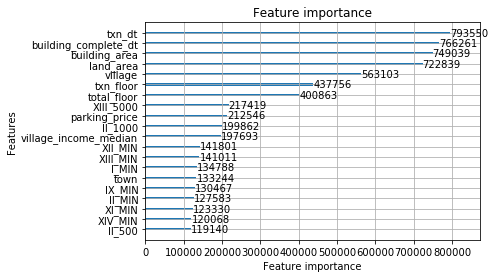

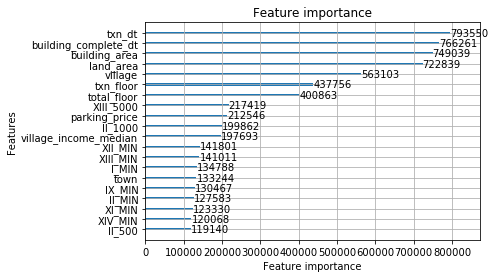

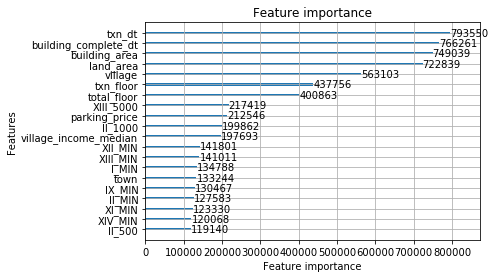

In [30]:
loss1 = model.evals_result_['training']['l1']
loss2 = model.evals_result_['valid_1']['l1']
plt.plot(loss1,label='training')
plt.plot(loss2,color='red',label='test')
plt.show()

In [31]:
lgb.plot_importance(model, max_num_features=20)

In [32]:
yhat = model.predict(X_test)

In [33]:
def score(yhat,y):
    z = 0
    z2 = 0
    total = 0
    for y1,y2 in zip(yhat,y):
        present = abs(y1-y2)/y2
        total += present
        if(present <= 0.1):
            z += 1
        if(present > 0.2):
            z2 += 1
    print('(1-total/len(y)) = ',(1-total/len(y)))
    print(f'> 20 % : {z2/len(y)}')
    return z/len(y),z/len(y)*10000 + (1-total/len(y))
hit_rate,point = score(yhat*X_test['building_area'].values,y_test*X_test['building_area'].values)

(1-total/len(y)) =  0.729910359419
> 20 % : 0.45666666666666667


In [34]:
hit_rate

0.30025

In [35]:
point

3003.2299103594191